In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
import torchvision.models as models
from itertools import groupby
from torchvision import datasets,transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize([256,256]),transforms.ToTensor()]) 


# hashing the embeding with random vector projection
def get_hash(vector_represenatation,hyperplanes):
    # Take the dot product of the input vector with each of the n hyperplanes
    projection = np.dot(np.array(vector_represenatation),hyperplanes.T)
    # Classify as a 1 or zero if the value is positive or negative
    projection = projection>0
    
    # hashed_values = []
    # for p in projection:
    #     print(p)
    #     hashed_values.append(int_converter(p))
    hashed_value = int_converter(projection)
    return hashed_value




def int_converter(boolean_array):
    bool_as_int = 0
    for bit in boolean_array:
        bool_as_int = (bool_as_int<<1)|bit
    return bool_as_int



def create_hyperplanes(number_of_hashes,vector_dimension):
    hyperplanes = np.random.randn(number_of_hashes,vector_dimension)
    return hyperplanes


'''
Class to hash values into boolean array, which is viewed as a bit array and 
converted to its corresponding integer value by int_converter
'''

class Hash_Table:
    
    def __init__(self, number_of_hashes, vector_dimension):
        self. number_of_hashes = number_of_hashes
        self.hyperplanes = create_hyperplanes(number_of_hashes, vector_dimension)
        self.hash_table = {} #initializing empty dictionary 
        
    def insert_hashes(self, file_number,embeddings):
        
        # location of the image in the original array 
        value = [file_number]
        
        #compute the hashed representation of the embeddings
        
        hashed_embeddings = get_hash(embeddings,self.hyperplanes)
        
        # for hashes in hashed_embeddings:
        for i in hashed_embeddings:
            if i in self.hash_table:
                self.hash_table[i].append(value)
            else:
                self.hash_table[i] = value
            
        

    def find_matches(self, input_embeddings):
        
        hashed_embeddings = get_hash(input_embedding,self.hyperplanes)
        
        # List to store the nearest neighbors from the location the 
        #input_embedding is hashed to

        nearest_neighbors = []
        
        for hashes in hashed_embeddings:
            if hashes in self.hash_table:
                nearest_neighbors.extend(self.hash_table[hashses])
        
        return nearest_neighbors
        
'''     
Class to create n internal tables (try to reduce the impact from a single
vector splitting points which are extremly close by)
'''
class Multi_Hash_Table:
    
    def __init__(self, number_of_hashes,vector_dimension,number_of_tables):
        self.number_of_tables = number_of_tables
        self.hash_tables  = []
        
        # Create number_of_tables tables
        for i in range(self.number_of_tables):
            self.hash_tables.append(Hash_Table(number_of_hashes,vector_dimension))
            
        
    def insert_hashes(self, file_number,embeddings):
        for hash_table in self.hash_tables:
            hash_table.insert_hashes(file_number,embeddings)
            
    def find_matches(self,input_embeddings):
        nearest_neighbors = []
        
        for hash_table in self.hash_tables:
            nearest_neighbors.extend(hash_table.find_matches(input_embeddings))
        
        return nearest_neighbors
            


'''
Class to store a set of images in their hashed formats for comparison against 
other images 
'''
class Projection_LSH:
    
    def __init__(self, model, number_of_hashes = 10,number_of_tables = 5,vector_dimension = 2048):
        self.model = model
        self.number_of_hashes = number_of_hashes
        self.number_of_tables = number_of_tables
        self.vector_dimension = vector_dimension
        self.multi_table = Multi_Hash_Table(self.number_of_hashes,
                                            self.vector_dimension,
                                            self.number_of_tables)

    def create_hash(self,datloader):
        # for file_number,(image,label) in enumerate(images):
        #     print
        #     image, label = image.to(device),label.to(device)
        #     reduced = test_res
        self.model.eval()
        feats = []


        with torch.no_grad():
            for file_number,(images,labels) in enumerate(dataloader):

                images, labels = images.to(device), labels.to(device)

                outputs = self.model(images)
                
                reduced = features['final_layer'].squeeze().unsqueeze(0).cpu().numpy()

                self.multi_table.insert_hashes(file_number = file_number,embeddings = reduced)


    def find_nearest_neighbors(self,image):
        
        reduced = self.model(image)
        
        nearest_neighbor = self.multi_tabel.find_matches(reduced)

        
        most_seen = {}
        for i in p:
            most_seen[i] = most_seen.get(i,0)+1
        
        y = dict(sorted(x.items(), key=lambda item: item[1],reverse = True))
        # neighbor_dict = {key:nearest_neighbors.count(key) for key in nearest_neighbors}
        
        return y
        

resnet = models.resnet50(pretrained = True)
resnet.to(device)
resnet.eval()

features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


def test_resnet(model,testloader):
    model.eval()
    feats = []


    with torch.no_grad():
        for idx,(images,labels) in enumerate(testloader):

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            feats.append(features['final_layer'].cpu().numpy())


    feats = np.concatenate(feats)
    return feats

batch_size = 1
TEST_IMAGE = '/Users/colehunter/Desktop/0x0.jpg'


resnet.avgpool.register_forward_hook(get_features('final_layer'))

data = datasets.ImageFolder('/projectnb/dl523/students/colejh/520/wikipaintings_small/wikipaintings_test',transform = transform)
dataloader = torch.utils.data.DataLoader(data, shuffle=False, batch_size=batch_size)

# img = Image.open(TEST_IMAGE)
# imgtensor = transform(img).unsqueeze(0).to(device)
# features = resnet(imgtensor)

table = Projection_LSH(resnet)
table.create_hash(dataloader)


In [ ]:
table.multi_table.hash_tables

Time to initialize table: 0.004562275484204292
Time to hash images: 6.180216372013092
[[0.11362872 0.29592603 0.         ... 0.         0.00870132 0.09383923]]
747
198
512
1000
355
Time to query selected image: 0.008232224732637405
{1: 5, 50: 1, 139: 1, 214: 1, 243: 1, 198: 1, 230: 1, 77: 1, 166: 1, 236: 1}


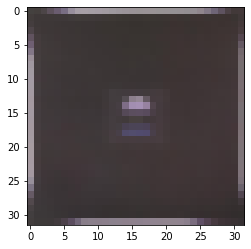

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
import torchvision.models as models
from itertools import groupby
from torchvision import datasets,transforms
from timeit import default_timer as timer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize([32,32]),transforms.ToTensor()]) 
TOP_K = 5

# hashing the embeding with random vector projection
def get_hash(vector_represenatation,hyperplanes):
    # Take the dot product of the input vector with each of the n hyperplanes
    projection = np.dot(np.array(vector_represenatation),hyperplanes.T)
    # Classify as a 1 or zero if the value is positive or negative
    projection = projection>0
    
    # hashed_values = []
    # for p in projection:
    #     print(p)
    #     hashed_values.append(int_converter(p))
    hashed_value = int_converter(projection[0])
    return hashed_value




def int_converter(boolean_array):
    bool_as_int = 0
    for bit in boolean_array:
        bool_as_int = (bool_as_int<<1)|bit
    return bool_as_int



def create_hyperplanes(number_of_hashes,vector_dimension):
    hyperplanes = np.random.randn(number_of_hashes,vector_dimension)
    return hyperplanes


'''
Class to hash values into boolean array, which is viewed as a bit array and 
converted to its corresponding integer value by int_converter
'''

class Hash_Table:
    
    def __init__(self, number_of_hashes, vector_dimension):
        self. number_of_hashes = number_of_hashes
        self.hyperplanes = create_hyperplanes(number_of_hashes, vector_dimension)
        self.hash_table = {} #initializing empty dictionary 
        
    def insert_hashes(self, file_number,embeddings):
        
        # location of the image in the original array 
        value = [file_number]
        
        #compute the hashed representation of the embeddings
        
        hashed_embeddings = get_hash(embeddings,self.hyperplanes)
        
        # for hashes in hashed_embeddings:
#         for i in hashed_embeddings:
        if hashed_embeddings in self.hash_table:
            self.hash_table[hashed_embeddings].extend(value)
        else:
            self.hash_table[hashed_embeddings] = value

        

    def find_matches(self, input_embedding):

        hashed_embeddings = get_hash(input_embedding,self.hyperplanes)

        # List to store the nearest neighbors from the location the 
        #input_embedding is hashed to
        print(hashed_embeddings)
        nearest_neighbors = []
        
#         for hashes in hashed_embeddings:
#             print('hashes final',hashes)
        if hashed_embeddings in self.hash_table:
            nearest_neighbors.extend(self.hash_table[hashed_embeddings])

        return nearest_neighbors
        
'''     
Class to create n internal tables (try to reduce the impact from a single
vector splitting points which are extremly close by)
'''
class Multi_Hash_Table:
    
    def __init__(self, number_of_hashes,vector_dimension,number_of_tables):
        self.number_of_tables = number_of_tables
        self.hash_tables  = []
        
        # Create number_of_tables tables
        for i in range(self.number_of_tables):
            self.hash_tables.append(Hash_Table(number_of_hashes,vector_dimension))
            
        
    def insert_hashes(self, file_number,embeddings):
        for hash_table in self.hash_tables:
            hash_table.insert_hashes(file_number,embeddings)
            
    def find_matches(self,input_embeddings):
        nearest_neighbors = []

        for hash_table in self.hash_tables:
            nearest_neighbors.extend(hash_table.find_matches(input_embeddings))

        
        return nearest_neighbors
            


'''
Class to store a set of images in their hashed formats for comparison against 
other images 
'''
class Projection_LSH:
    
    def __init__(self, model, number_of_hashes = 1,number_of_tables = 5,vector_dimension = 2048):
        self.model = model
        self.number_of_hashes = number_of_hashes
        self.number_of_tables = number_of_tables
        self.vector_dimension = vector_dimension
        self.multi_table = Multi_Hash_Table(self.number_of_hashes,
                                            self.vector_dimension,
                                            self.number_of_tables)

    def create_hash(self,datloader):
        # for file_number,(image,label) in enumerate(images):
        #     print
        #     image, label = image.to(device),label.to(device)
        #     reduced = test_res
        self.model.to(device)
        self.model.eval()
        feats = []


        with torch.no_grad():
            for file_number,(images,labels) in enumerate(dataloader):

                images, labels = images.to(device), labels.to(device)

                outputs = self.model(images)
                
                reduced = features['final_layer'].squeeze().unsqueeze(0).cpu().numpy()

                self.multi_table.insert_hashes(file_number = file_number,embeddings = reduced)


    def find_nearest_neighbors(self,image):
        image = image.to(device)
        out = self.model(image)
        reduced = features['final_layer'].squeeze().unsqueeze(0).cpu().numpy()
        print(reduced)
        nearest_neighbor = self.multi_table.find_matches(reduced)

        most_seen = {}
        for i in nearest_neighbor:
            most_seen[i] = most_seen.get(i,0)+1
        
        y = dict(sorted(most_seen.items(), key=lambda item: item[1],reverse = True))
        # neighbor_dict = {key:nearest_neighbors.count(key) for key in nearest_neighbors}
        
        return y
        

resnet = models.resnet50(pretrained = True)
resnet.to(device)
resnet.eval()

features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


def test_resnet(model,testloader):
    model.eval()
    feats = []


    with torch.no_grad():
        for idx,(images,labels) in enumerate(testloader):

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            feats.append(features['final_layer'].cpu().numpy())


    feats = np.concatenate(feats)
    return feats

batch_size = 1
TEST_IMAGE = '/projectnb/dl523/students/colejh/520/wikipaintings_small/wikipaintings_test/Abstract_Art/adnan-coker_er-eve-1999.jpg'

test = Image.open(TEST_IMAGE)
testtens = transform(test).unsqueeze(0)

resnet.avgpool.register_forward_hook(get_features('final_layer'))

data = datasets.ImageFolder('/projectnb/dl523/students/colejh/520/wikipaintings_small/wikipaintings_test',transform = transform)
dataloader = torch.utils.data.DataLoader(data, shuffle=False, batch_size=batch_size)

# img = Image.open(TEST_IMAGE)
# imgtensor = transform(img).unsqueeze(0).to(device)
# features = resnet(imgtensor)

start = timer()
table = Projection_LSH(resnet,number_of_hashes = 10)
end = timer()
print('Time to initialize table:', end-start)
start = timer()
table.create_hash(dataloader)
end = timer()
print('Time to hash images:', end-start)
start = timer()
a = table.find_nearest_neighbors(testtens)
end = timer()
print('Time to query selected image:', end-start)
print(a)



(569, 570, 3)


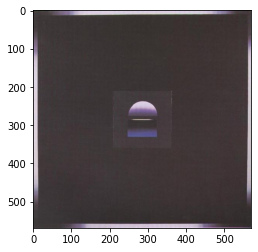

In [26]:
j = np.asarray(test)
print(j.shape)
plt.imshow(j);

count 0


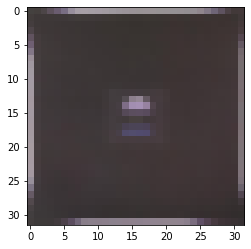

count 1


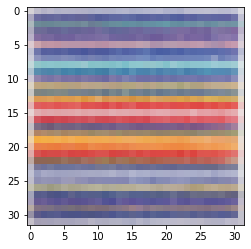

count 2


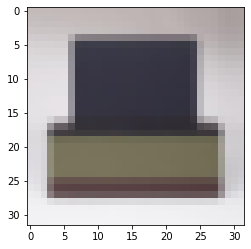

count 3


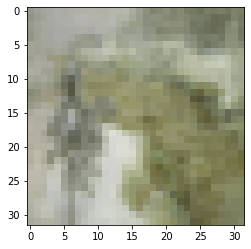

count 4


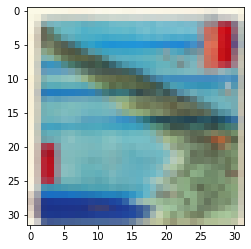

count 5


In [19]:
TOP_K = 5
count = 0
images = []
labels = []
images.append()
for key,value in a.items():
    print('count',count)
    if count>=TOP_K:
        break
    else:
        imgs
        plt.imshow(data[key][0].permute(1,2,0))
        plt.show()

    count+=1

    
fig = plt.figure(figsize=(25., 25.))
        grid = ImageGrid(fig, 111,  
                         nrows_ncols=(1,6), 
                         axes_pad=0.3, 
                         )
        for ax, im,lab in zip(grid, imgs,labels):

            ax.imshow(im)
            ax.set_title(lab)
        plt.show()

In [ ]:
resnet = models.resnet50(pretrained = True)
resnet.eval()


In [ ]:
from torchsummary import summary
# hook for the selected input layer [name] in ViT model
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook



In [ ]:
from torchvision import datasets,transforms

TEST_IMAGE = '0x0.jpg'
transform = transforms.Compose([transforms.Resize(256),transforms.ToTensor()]) 

resnet.avgpool.register_forward_hook(get_features('final_layer'))

data = datasets.ImageFolder('/projectnb/dl523/projects/Sarcasm/wikipaintings_full/wikipaintings_test',transform = transform)


img = Image.open(TEST_IMAGE)
imgtensor = transform(img).unsqueeze(0).to(device)
features = resnet(imgtensor)
